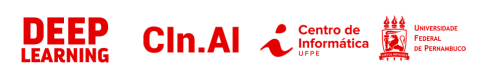

In [ ]:
#http://alexminnaar.com/2019/08/22/ner-rnns-tensorflow.html
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import numpy as np
import os
import time

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.11.0


In [ ]:
import nltk
nltk.download('conll2002')

train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
dev_sents = list(nltk.corpus.conll2002.iob_sents('esp.testa'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [ ]:
print("train_sents: ", len(train_sents))
print("test_sents: ", len(test_sents))
print("dev_sents: ", len(dev_sents))

train_sents:  8323
test_sents:  1517
dev_sents:  1915


In [ ]:
dev_sents[40]

[('Un', 'DI', 'O'),
 ('subalterno', 'NC', 'O'),
 ('de', 'SP', 'O'),
 ('lujo', 'NC', 'O'),
 ('en', 'SP', 'O'),
 ('la', 'DA', 'O'),
 ('cuadrilla', 'NC', 'O'),
 ('del', 'SP', 'O'),
 ('salmantino', 'NC', 'O'),
 (',', 'Fc', 'O'),
 ('Domingo', 'NC', 'B-PER'),
 ('Siro', 'AQ', 'I-PER'),
 (',', 'Fc', 'O'),
 ('abundó', 'VMI', 'O'),
 ('en', 'SP', 'O'),
 ('mejorar', 'VMN', 'O'),
 ('el', 'DA', 'O'),
 ('ambiente', 'NC', 'O'),
 ('con', 'SP', 'O'),
 ('dos', 'DN', 'O'),
 ('excelentes', 'AQ', 'O'),
 ('pares', 'NC', 'O'),
 ('de', 'SP', 'O'),
 ('banderillas', 'NC', 'O'),
 ('.', 'Fp', 'O')]

In [ ]:
def select_data(data):
  examples = []

  for sent in data:
    sample = []
    for triple in sent:
      sample.append([triple[0], triple[2]])  # seleciona apenas o primeiro e o terceiro elementos da tripla (NER)
    examples.append(sample)

  return examples

In [ ]:
train_examples = select_data(train_sents)
test_examples = select_data(test_sents)
dev_examples = select_data(dev_sents)

In [ ]:
train_examples[0]

[['Melbourne', 'B-LOC'],
 ['(', 'O'],
 ['Australia', 'B-LOC'],
 [')', 'O'],
 [',', 'O'],
 ['25', 'O'],
 ['may', 'O'],
 ['(', 'O'],
 ['EFE', 'B-ORG'],
 [')', 'O'],
 ['.', 'O']]

In [ ]:
# Construir o vocabulário
vocab = set([])
for sample in train_examples+test_examples+dev_examples:
  for token in sample:
    vocab.add(token[0])
print(vocab)

{'Hashim', 'guayanesas', 'ESPECIE', 'condicionado', 'democráticos', 'a', 'lógica', 'Orgullo', 'Canto', 'memoria', 'Empresas.', 'mesas', 'Yucatán', 'Autónomas', 'adjunta', '777', 'Sanchis', 'zurdo', 'alimentarios', '17894', 'mc/Sab', 'vulnerando', 'suprime', 'Barcina', 'ambientales', 'aplaza', 'evidenciado', 'excepción', 'insignificantes', 'Sampras', 'Blanca', 'acondicionamiento', 'coadyuva', '107,13', 'asesor', '31,92', '================================================', 'Pasqual', 'Procurador', 'Duero', 'estipule', 'apuntaló', 'educativos', 'Huguet', 'Prinosil', 'Martutene', 'Seminario', 'deportará', 'Zala', 'Casablanca', 'episcopales', 'cultivar', '0,28%', 'arroja', 'marcaje', 'pude', 'hija', 'Teixeira', 'precariedad', 'reconocida', 'orientación', 'mantenerse', 'Shukur', 'corroborada', 'australiana', 'I.', 'tajantemente', 'Cascos', 'elabora', 'enaltecida', 'improductivas', 'estipula', 'Recuperación.', 'histórico', 'MANDRAGORA', 'capital', 'Burgos', 'continuará', 'tengan', 'Koresh', '

In [ ]:
# Vocabulário de labels que podem ser assumidos pelas palavras
labels = set([])
for sample in train_examples+test_examples+dev_examples:
  for token in sample:
    labels.add(token[1])
print(labels)

{'I-PER', 'B-PER', 'I-LOC', 'O', 'B-LOC', 'B-MISC', 'I-ORG', 'I-MISC', 'B-ORG'}


In [ ]:
# alfabeto (caracteres)
all_text = " ".join([" ".join(char) for token in vocab for char in token])
vocab = sorted(set(all_text))
print(vocab)

[' ', '!', '"', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '·', '¿', 'Ñ', 'à', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü']


In [ ]:
# create character/id and label/id mapping
char2idx = {u:i+1 for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
label2idx = {u:i+1 for i, u in enumerate(labels)}
idx2label = {i+1:u for i, u in enumerate(labels)}

print(idx2label)
print(label2idx)
print(char2idx)

{1: 'I-PER', 2: 'B-PER', 3: 'I-LOC', 4: 'O', 5: 'B-LOC', 6: 'B-MISC', 7: 'I-ORG', 8: 'I-MISC', 9: 'B-ORG'}
{'I-PER': 1, 'B-PER': 2, 'I-LOC': 3, 'O': 4, 'B-LOC': 5, 'B-MISC': 6, 'I-ORG': 7, 'I-MISC': 8, 'B-ORG': 9}
{' ': 1, '!': 2, '"': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '+': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '=': 26, '?': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80, '¡': 81, '·': 82, '¿': 83, 'Ñ': 84, 'à': 85, 'á': 86, 'é': 87, 'í': 88, 'ñ

In [ ]:
def split_char_labels(eg):
  '''
  For a given input/output example, break tokens into characters while keeping
  the same label.
  '''

  input_chars = []
  output_char_labels = []
  for token, label in eg:
    input_chars.extend([char for char in token])
    input_chars.extend(' ')
    output_char_labels.extend([label]*len(token))
    output_char_labels.extend('O')

  return [[char2idx[x] for x in input_chars[:-1]], np.array([label2idx[x] for x in output_char_labels[:-1]])]

train_formatted = [split_char_labels(eg) for eg in train_examples]
test_formatted = [split_char_labels(eg) for eg in test_examples]
valid_formatted = [split_char_labels(eg) for eg in dev_examples]

print(len(train_formatted))
print(len(test_formatted))
print(len(valid_formatted))

8323
1517
1915


In [ ]:
train_examples[0]

[['Melbourne', 'B-LOC'],
 ['(', 'O'],
 ['Australia', 'B-LOC'],
 [')', 'O'],
 [',', 'O'],
 ['25', 'O'],
 ['may', 'O'],
 ['(', 'O'],
 ['EFE', 'B-ORG'],
 [')', 'O'],
 ['.', 'O']]

In [ ]:
# training generator
def gen_train_series():

    for eg in train_formatted:
      yield eg[0], eg[1]

# validation generator
def gen_valid_series():

    for eg in valid_formatted:
      yield eg[0], eg[1]

# test generator
def gen_test_series():

  for eg in test_formatted:
      yield eg[0], eg[1]

# create Dataset objects for train, test and validation sets
series = tf.data.Dataset.from_generator(gen_train_series, output_types=(tf.int32, tf.int32), output_shapes = ((None, None)))
series_valid = tf.data.Dataset.from_generator(gen_valid_series, output_types=(tf.int32, tf.int32), output_shapes = ((None, None)))
series_test = tf.data.Dataset.from_generator(gen_test_series, output_types=(tf.int32, tf.int32), output_shapes = ((None, None)))

BATCH_SIZE = 256
BUFFER_SIZE = 1000  # random seed

# create padded batch series objects for train, test and validation sets
ds_series_batch = series.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_valid = series_valid.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_test = series_test.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)

# print example batches
for input_example_batch, target_example_batch in ds_series_batch_valid.take(1):
  print(input_example_batch)
  print(target_example_batch)


tf.Tensor(
[[47 55 69 ...  0  0  0]
 [11  0  0 ...  0  0  0]
 [40 55  1 ...  0  0  0]
 ...
 [33 68  1 ...  0  0  0]
 [32 59 73 ...  0  0  0]
 [33 68  1 ...  0  0  0]], shape=(256, 453), dtype=int32)
tf.Tensor(
[[5 5 5 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 ...
 [4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]], shape=(256, 453), dtype=int32)


In [ ]:
vocab_size = len(vocab)+1

# The embedding dimension
embedding_dim = 50

# Number of RNN units
rnn_units = 50

label_size = len(labels)

# build LSTM model
def build_model(vocab_size, label_size, embedding_dim, rnn_units, batch_size):
      model = tf.keras.Sequential([
          tf.keras.layers.Embedding(vocab_size, embedding_dim,   #batch_input_shape=[batch_size, None],
                            mask_zero=True),
          tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      #stateful=True,
                      recurrent_initializer='glorot_uniform'),
          tf.keras.layers.Dense(label_size)
          ])
      return model

model = build_model(
      vocab_size = len(vocab)+1,
      label_size = len(labels)+1,
      embedding_dim = embedding_dim,
      rnn_units = rnn_units,
      batch_size = BATCH_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          4650      
                                                                 
 lstm (LSTM)                 (None, None, 50)          20200     
                                                                 
 dense (Dense)               (None, None, 10)          510       
                                                                 
Total params: 25,360
Trainable params: 25,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os

# define loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS=10
history = model.fit(ds_series_batch, epochs = EPOCHS, validation_data = ds_series_batch_valid, callbacks=[checkpoint_callback])

Epoch 1/10
32/32 [==============================] - 107s 3s/step - loss: 1.3943 - sparse_categorical_accuracy: 0.8263 - val_loss: 0.8245 - val_sparse_categorical_accuracy: 0.8427
Epoch 2/10
32/32 [==============================] - 94s 3s/step - loss: 0.7039 - sparse_categorical_accuracy: 0.8637 - val_loss: 0.7724 - val_sparse_categorical_accuracy: 0.8427
Epoch 3/10
32/32 [==============================] - 96s 3s/step - loss: 0.6867 - sparse_categorical_accuracy: 0.8637 - val_loss: 0.7626 - val_sparse_categorical_accuracy: 0.8428
Epoch 4/10
32/32 [==============================] - 92s 3s/step - loss: 0.6764 - sparse_categorical_accuracy: 0.8636 - val_loss: 0.7494 - val_sparse_categorical_accuracy: 0.8425
Epoch 5/10
32/32 [==============================] - 93s 3s/step - loss: 0.6614 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.7277 - val_sparse_categorical_accuracy: 0.8423
Epoch 6/10
32/32 [==============================] - 92s 3s/step - loss: 0.6324 - sparse_categorical_accuracy:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = np.array([])
y_trues= np.array([])

# iterate through test set, make predictions based on trained model
for input_example_batch, target_example_batch in ds_series_batch_test:

  pred=model.predict_on_batch(input_example_batch)
  pred_max=tf.argmax(tf.nn.softmax(pred), 2).numpy().flatten()
  y_true=target_example_batch.numpy().flatten()

  preds=np.concatenate([preds,pred_max])
  y_trues=np.concatenate([y_trues,y_true])

# remove padding from evaluation
remove_padding = [(p,y) for p,y in zip(preds,y_trues) if y!=0]

r_p = [x[0] for x in remove_padding]
r_t = [x[1] for x in remove_padding]

In [ ]:
# print confusion matrix and classification report
#print(confusion_matrix(r_p,r_t))
print(classification_report(r_p,r_t, target_names=list(labels)))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       I-PER       0.08      0.40      0.13       656
       B-PER       0.00      0.00      0.00         0
       I-LOC       0.00      0.00      0.00         0
           O       0.99      0.98      0.98    204051
       B-LOC       0.03      0.26      0.06       769
      B-MISC       0.00      0.00      0.00         0
       I-ORG       0.62      0.32      0.42     10488
      I-MISC       0.00      0.00      0.00         1
       B-ORG       0.75      0.32      0.45     17297

    accuracy                           0.89    233262
   macro avg       0.27      0.25      0.23    233262
weighted avg       0.95      0.89      0.91    233262



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
